In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf 
# Python yfinance kütüphanesi, kodu belirtilen hissenin günlük, anlık stok değerlerini çekmeye yarıyor. 
# Manuel hisse kodu belirtmektense, KAP’dan aldığımız ve sürekli güncellenen hisse kodları sayesinde, yfinance modülünden verileri otomatize ederek alabiliriz.
# Basit bir döngü ile BIST’deki tüm hisselerin verilerini çekebiliriz.

from yahoofinancials import YahooFinancials
# Yahoo Finance, finansal haberler, hisse senedi fiyatları, basın bültenleri ve finansal raporlar hakkında veriler sağlayan bir medya platformudur

import plotly.graph_objects as go
from stldecompose import decompose

# Seasonal-Trend-Loess Method 

In [308]:
thy_df = yf.download ('TKHVY',
                       start='2017-01-01',
                       progress=False)

thy_df.index = pd.to_datetime(thy_df.index)

# burada gün bazında açılış, en yüksek, en düşük ve kapanış değerleri var.
# ve adjusted kapanış değeri var ve volume değeri var
# şiddetini de volume columns'ı ile anlayabiliyoruz

In [309]:
close_thy = thy_df.iloc[:len(thy_df)//2,3]
close_thy.head()

Date
2017-01-03    14.11
2017-01-04    13.77
2017-01-05    13.77
2017-01-06    13.77
2017-01-09    13.02
Name: Close, dtype: float64

In [310]:
rolling_app5 = close_thy.rolling(window=5).mean() # rolling = yuvarlama
rolling_app14 = close_thy.rolling(window=14).mean()
rolling_app21 = close_thy.rolling(window=21).mean()

In [311]:
MAs = pd.concat([close_thy, rolling_app5, rolling_app14, rolling_app21], axis=1)
MAs.columns = ['Close', 'short', 'mid', 'long']

In [312]:
MAs.head()

,Close,short,mid,long
Date,,,,
2017-01-03,14.11,NaN,NaN,NaN
2017-01-04,13.77,NaN,NaN,NaN
2017-01-05,13.77,NaN,NaN,NaN
2017-01-06,13.77,NaN,NaN,NaN
2017-01-09,13.02,13.688,NaN,NaN


In [313]:
MAs.dropna(axis=0, inplace=True) # NaN dönen verileri siliyoruz
MAs.head(5)

,Close,short,mid,long
Date,,,,
2017-02-01,14.64,14.128,13.785714,13.670476
2017-02-02,14.64,14.296,13.879286,13.695715
2017-02-03,14.64,14.464,13.965715,13.737143
2017-02-06,14.64,14.632,14.052143,13.778572
2017-02-07,14.64,14.640,14.127857,13.820000


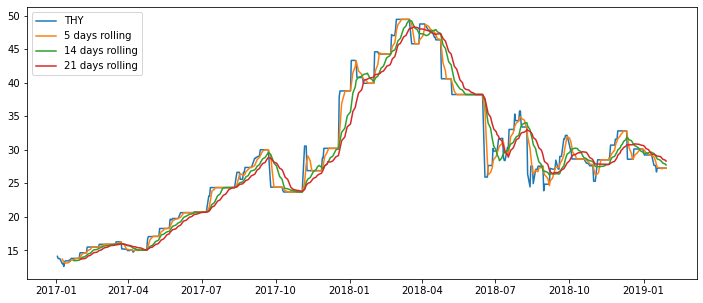

In [314]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(close_thy.index, close_thy, label='THY')
ax.plot(rolling_app5.index, rolling_app5, label='5 days rolling')
ax.plot(rolling_app14.index, rolling_app14, label='14 days rolling')
ax.plot(rolling_app21.index, rolling_app21, label='21 days rolling')
ax.legend(loc='upper left')
# maviler Türk Hava Yollarının ilgili zamanlarda kapanış değerleri oluyor
# 21 günlük hareketli ortalama aşağıda ise bize 14 ile 5 günlük ortalamalar onun üstünde ise yani artış eğiliminde diyebiliriz
# biz bu uzaklıkları kullanarak al, sat tavsiyesi verdireceğiz 
# şöyle yüksek düşüşlere alış, yüksek yükselişlere ise satış diyeceğiz 
# bunun için bir function yazacağız 

### Percentile - Yüzdebirlik Yöntemi
#### Betimsel istatistik içinde, bir yüzdebirlik sıralanmış bir veri serisini yüz eşit parçaya bölen ve böylece her bir bölünen parçanın anakütle veya örneklem verilerinin 1/100'ini kapsadığı, 99 tane özetleme değeridir. Betimsel istatistikte yüzdebirlikler çok popüler olarak kullanılır

#### Aslında şöyle kırmızı altta yeşil ortada turuncu üstte olduğunda her zaman al sinyali verme veya sat sinyali verme 
#### Bu çizgiler arasında istatiksel veya matematiksel olarak bir farklılık oluşsun ve anlamlı bir sonuç çıkaralım ve bu tavsiyeyi verelim

In [315]:
MAs["short"]-MAs["mid"] 
# bu bize aslında turuncu eksi yeşili ifade ediyor ve tarihsel olduğu için sıralı değil 
# ben bunun tüm verisetindeki hareketliliğini incelemek istiyorum ve bu farkı hesaba katacağım
# buradaki farklılığı belli bir percentile üzerinden dataya bağlı kalarak vermek istiyorum 

Date
2017-02-01    0.342286
2017-02-02    0.416714
2017-02-03    0.498286
2017-02-06    0.579857
2017-02-07    0.512143
                ...   
2019-01-23   -1.058857
2019-01-24   -0.996857
2019-01-25   -0.742857
2019-01-28   -0.602857
2019-01-29   -0.462857
Length: 501, dtype: float64

In [316]:
np.array(MAs["short"]-MAs["mid"]) # np.array veriyoruz matematiksel işlemlerde çok işimize yarıyor 
# bu veri seti sıralı değil, bu veri setini sıralayıp yüzde 10'luk percentile'ını almak istiyorum

array([ 3.42285769e-01,  4.16714341e-01,  4.98285798e-01,  5.79857254e-01,
        5.12142931e-01,  4.22857216e-01,  4.72142846e-01,  5.21428476e-01,
        5.70714106e-01,  6.19999736e-01,  6.69285366e-01,  5.48571110e-01,
        4.27856854e-01,  3.64285469e-01,  3.03571224e-01,  2.42856979e-01,
        2.34857001e-01,  2.26857022e-01,  2.18857043e-01,  2.10857064e-01,
        2.63571330e-01,  2.34285627e-01,  2.04999924e-01,  1.75714220e-01,
        1.46428517e-01,  1.17142814e-01,  8.78571102e-02,  5.85714068e-02,
        2.92857034e-02,  0.00000000e+00,  5.14285224e-03,  5.27143887e-02,
        1.00285925e-01,  1.47857462e-01,  1.95428998e-01,  2.35000542e-01,
        7.10003989e-02, -9.29997444e-02, -2.60856996e-01, -4.28714248e-01,
       -5.96571500e-01, -5.76142883e-01, -5.55714267e-01, -5.16428634e-01,
       -4.74285861e-01, -4.08571598e-01, -3.46571677e-01, -2.35714599e-01,
       -1.56428732e-01, -7.71428653e-02, -7.42856162e-02, -3.42833655e-03,
       -5.57106563e-03,  

In [320]:
np.percentile(np.array(MAs["short"]-MAs["mid"]),10)
# senin short ile mid arasındaki en küçük %10.cu değeri
# - olduğu için medium long'dan büyük oluyor, senin en küçük uzaklığın buymuş diyoruz   
# tüm uzaklıkları hesaba katmasını ve bunu mutlak değere 

0.0

In [318]:
np.abs(np.percentile(np.array(MAs["short"]-MAs["mid"]),10))
# tüm uzaklıkları hesaba katmasını ve bunu mutlak değere çevir ve function'da bize + ve - olarak kullanılsın
# bu uzaklık ise optimum uzaklığı seçmeye çalışıyoruz 
# buy_sell içindeki perc değiştirebiliriz her veri setine göre özgü olabilir 

1.559999738420757

In [328]:
def buy_sell(data, perc=60):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42
    
    sm = np.abs(np.percentile(np.array(data["short"] - data["mid"]),perc)) # small ve medium değerlerin içinde olduğu object
    sl = np.abs(np.percentile(np.array(data["short"] - data["long"]),perc)) # small ve long değerlerin içinde olduğu object
    
    for i in range(0,len(data)):
        if (data["short"][i] > data["mid"][i]+sm) & (data["short"][i] > data["long"][i]+sl): # ilk hedefim shortları medium ile karşılaştırmak ilgili percentile değerini de ekleyerek yani ilk kesişim noktası değilde ortasını yakalamaya çalışıyorum mediumu artırarak, yani amacım sell
            buy_signal.append(np.nan)
            if flag != 1: # flag'i 42 verdik eğer değilse aşağıdaki işlemi uygula diyoruz
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i]) # 
                flag = 1 # burada ise flag'i 1 yapıyoruz
            else:
                 sell_signal.append(np.nan)
        elif (data["short"][i] < data["mid"][i]-sm) & (data["short"][i] < data["long"][i]-sl): # artık turuncum aşağı gelsin, kırmızı ve yeşil yukarıda kallsın ve uzak olsun birbirlerine short medium değerlerini medium'dan çıkarıyorum. Short,long değerini longlardan çıkarıyorum ve turuncuları biraz uzaklaştırmaya çalışıyoruz  
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag = 0
            else: 
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan) # kullanmadığım değişkenleri de nan atıyorum yukarıdakileri
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
   
    operations = np.array(buy_sell) 
    operations = operations[~np.isnan(operations)] #burada ise buyselleri alıyoruz np.array'a atayıp, nanları kaldırıyoruz
    # alış olanlar -, satış olanlar +, olarak görebiliriz. bir seri elde ederiz ama alış'dan başlayacağımız için ilk olarak - ile başlat süreci + değer ile bitir diyoruz
    
    neg = 0 # negatif ve pozitif değerler atıyoruz indexleri 0
    pos = 0
    
    for i in range(len(operations)): # for döngüsü içinde operations elemanının 1. elemanı 0'dan küçükse eğer o elemana 0. değeri ata çık döngüden
        if operations[i] < 0:
            neg = i
            break
    for i in range(1,len(operations)): # aynı işlemi pozitif değerler içinde yap
        if operations[-i] > 0:
            pos = i-1
            break
    operations = operations[neg:-pos]
    PL = np.sum(operations) # burada da sum ile toplatarak kar mı ettim zarar mı ettim onu buluyorum 
    
    return (buy_signal, sell_signal, PL)


In [329]:
m = buy_sell(MAs)
m
# burada da array içinde görebiliriz
# bizim buradaki amacımız -26 ile girip 18 ile çıkmak olacaktır

([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

In [330]:
m = buy_sell(MAs)
MAs["BUY"] = m[0]
MAs["SELL"] = m[1]

In [331]:
len(m[0])

501

<function matplotlib.pyplot.show(close=None, block=None)>

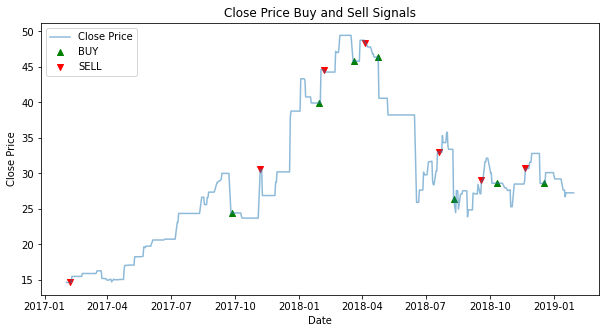

In [332]:
plt.figure(figsize=(10,5))
plt.scatter(MAs.index, MAs["BUY"], color = "green", label = "BUY", marker='^', alpha=1)
plt.scatter(MAs.index, MAs["SELL"], color = "red", label = "SELL", marker='v', alpha=1)
plt.plot(MAs["Close"], label = "Close Price", alpha=0.5)
plt.title("Close Price Buy and Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc = "upper left")
plt.show

In [333]:
m[2]*1000 # m'in içindeki 2.değeri çıkarmalıyım 
# ilk yeşilden başlarsak örneğin her alış'da 1000$'lık alış yaparsak 
# aşağıdan yukarıya kendi içinde kar eden bir yapı kurmuş oluruz 
# 1000$'da 4800$ kazandıran vadesi ise 

4729.9957275390625

In [334]:
MAs.index[1]-MAs.index[-1] # 726 günde bu karı etmiş oluruz, bu optimize edilebilir percentile sayısını değiştirerek 
# her bir data için doğru percentile'ı bulur ve optimum seviye olur 

Timedelta('-726 days +00:00:00')